In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
import napari
import itk

from pathlib import Path
import time

%matplotlib inline

# Test of the lung navigation problem
In this notebook, we want to present iterative solutions of the lung navigation problem using harmonic navigation functions.
We decompose the study in 3 parts : 
- the solution of the heat equation at rest
- the Poisson equation with Dirichlet boundary condition (bc)
- the Poisson equation with the source beeing a bc  

Let's first define the numerical scheme for estimating the Laplace equation

## Finite difference laplacian with Dirichlet boundary conditions 

In [2]:
def create_laplacian_matrix_2d(
    nx: int, ny: int, dx: float, dy: float
) -> sp.lil_array:
    Dxx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Dyy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
    return sp.kronsum(Dyy, Dxx, format="csr")

def create_laplacian_matrix_3d(
    nx: int, ny: int, nz: int, dx: float, dy: float, dz: float
) -> sp.lil_array:
    # Compute the 2D laplacian matrix
    laplace_2d = create_laplacian_matrix_2d(nx, ny, dx, dy)

    Dzz = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nz, nz)) / dz**2
    return sp.kronsum(Dzz, laplace_2d, format="csr")

In [3]:
# Definition of functions to convert between indices and subscripts
def ind2sub_2D(array_shape, ind):
    rows = (ind / array_shape[1])
    cols = ind % array_shape[1]
    return np.array([rows, cols], dtype='int')

def sub2ind_2D(array_shape, rows, cols):
    return int(rows*array_shape[1] + cols)

def ind2sub_3D(array_shape, ind):
    rows = (ind / (array_shape[1]*array_shape[2]))
    cols = (ind / array_shape[2]) % array_shape[1]
    slices = ind % array_shape[2]
    return np.array([rows, cols, slices], dtype='int')

def sub2ind_3D(array_shape, rows, cols, slices):
    return int(rows*array_shape[1]*array_shape[2] + cols*array_shape[2] + slices)

[Text(0.5, 1.0, '3D Laplacian matrix')]

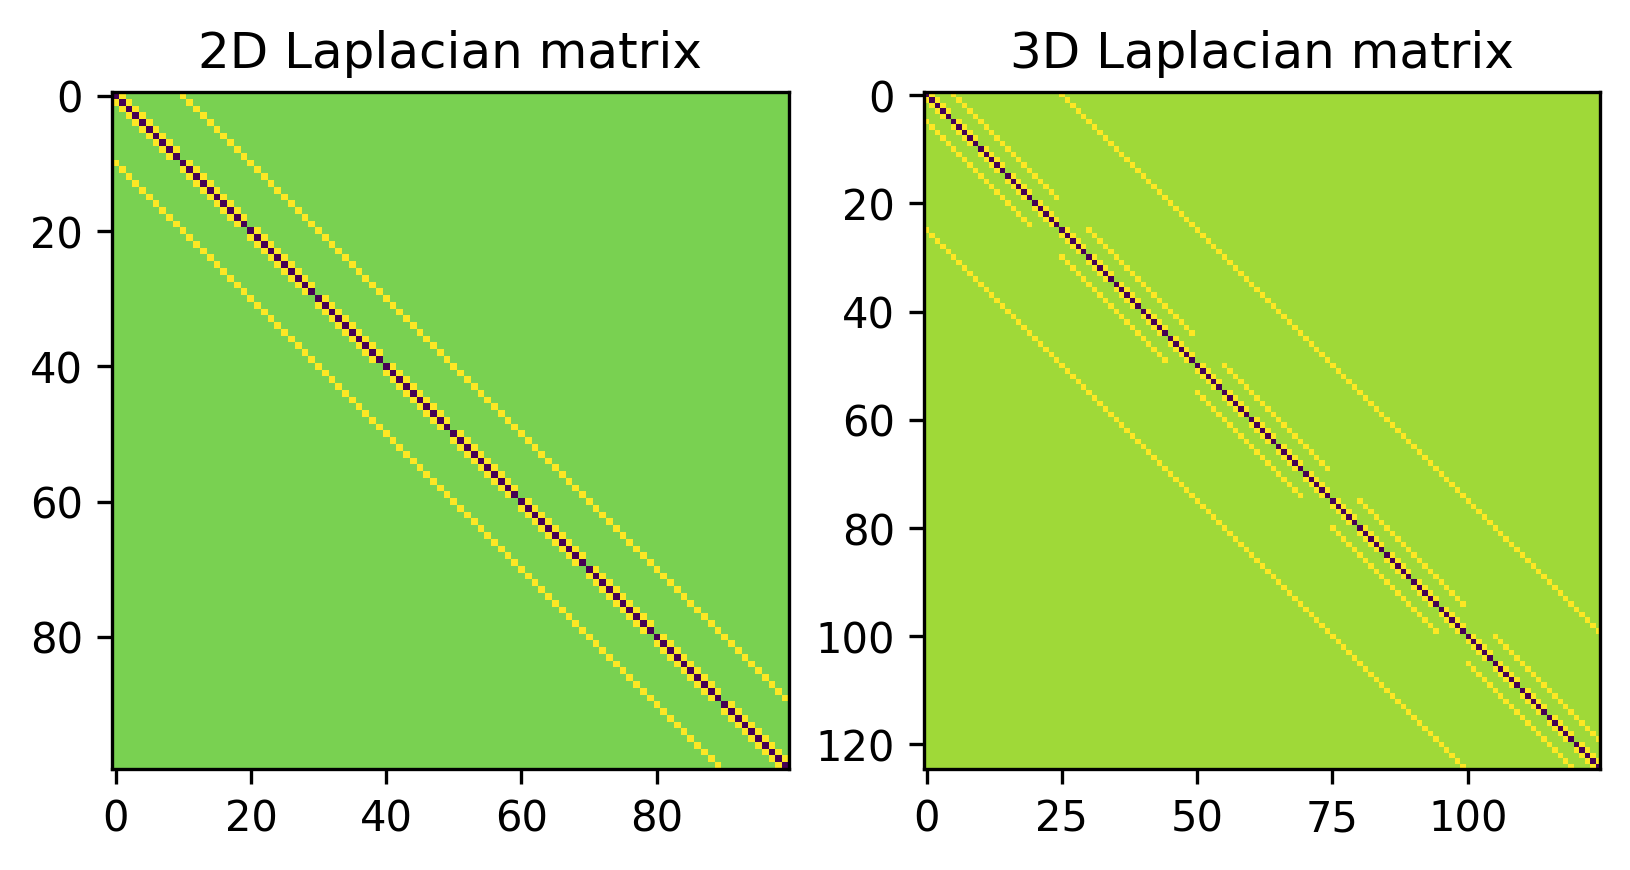

In [4]:
# Exemple of 2D and 3D laplacian matrix
laplacian2D = create_laplacian_matrix_2d(10, 10, 1, 1)
laplacian3D = create_laplacian_matrix_3d(5, 5, 5, 1, 1, 1)
fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(laplacian2D.toarray())
ax[0].set(title="2D Laplacian matrix")
ax[1].imshow(laplacian3D.toarray())
ax[1].set(title="3D Laplacian matrix")

In [ ]:
# Comparision with the laplacian matrix from scipy.ndimage
laplacian2D_sp = splinalg.LaplacianNd((10, 10), boundary_conditions='dirichlet')
laplacian3D_sp = splinalg.LaplacianNd((5, 5, 5), boundary_conditions='dirichlet')
fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(laplacian2D_sp.toarray())
ax[0].set(title="2D Laplacian matrix")
ax[1].imshow(laplacian3D_sp.toarray())
ax[1].set(title="3D Laplacian matrix")

assert  np.array_equal(laplacian2D.toarray(), laplacian2D_sp.toarray())
assert  np.array_equal(laplacian3D.toarray(), laplacian3D_sp.toarray())

# Transformation of the labels in a discretized domain
Now that we have our matrix representation of the laplacian, we need to adapt it to the sparse domain represented by the label mask of the lung. For doing so, we first need to import the geometry and reduce the dimension of the computing domain  

In [5]:
# Read the label mask of the lung with its spacing informations
label_path = (
    Path('.').resolve()
    .joinpath("sample_datas", "label.nii.gz")
    .resolve(strict=True)
)
itk_label = itk.imread(label_path)

steps = itk_label["spacing"]
label_view = itk.array_view_from_image(itk_label)
# We keep only the points inside the bounding-box of the label mask + some margin
margin = 1 # number of pixels to add around the bounding-box
label = label_view[ndi.find_objects(ndi.binary_dilation(label_view, iterations=margin))[0]]
# label = label_view[ndi.find_objects(label_view)[0]]

res = label.shape
print(f"Resolution: {res}, Steps: {steps}")

viewer = None

Resolution: (462, 139, 235), Steps: [0.5       0.8203125 0.8203125]


If we need to view the geometry first and its superposition with the medical image, we can run the following script

In [ ]:
# Read the image of the lung with its spacing informations
image_path = (
    Path('.')
    .joinpath("sample_datas", "image.nii.gz")
    .resolve(strict=True)
)
itk_image = itk.imread(image_path)
image_view = itk.array_view_from_image(itk_image)

# view the image and its superposition with the labels in napari
viewer = napari.view_image(image_view, name="image", scale=steps)
viewer.add_image(label_view, name="label", opacity=0.5, scale = steps, blending="additive", colormap="red")
napari.run()

# Definition of the initial configuration and the goal region 
In order to define our problem of path planning, we need to define a starting configuration and a goal region.
In order to do so, we propose to select the goal at the begining of the lung and the starting configuration at the middle of the lung, as represented bellow : 

In [ ]:
nb_slices = label.shape[0]
initial_position = (nb_slices // 2, 80, 100)
goal_position = (nb_slices-2, 53, 128)

fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(label[nb_slices-2, :, :], cmap="gray", origin="lower")
ax[0].plot(128, 53, "ro")
ax[0].set(title=f"Goal position - slice {nb_slices-2}")
ax[1].imshow(label[nb_slices // 2, :, :], cmap="grey", origin="lower")
ax[1].plot(100, 80, "bo")
ax[1].set(title=f"Initial position - slice {nb_slices // 2}")
fig.show()

We can see from the a above exemple that the starting configuration is at position (231, 80, 100) and a condidate goal position is located at (460, 53, 128). This values will be used to define the boundary conditions in the laplacian matrix

# Absorbing boundary conditions mimicking concentration
In this setup, we are interested about modeling the following system at stationarity where $x_0$ is the position of the goal:

$$\begin{cases} 
\partial_t C = D\Delta C + C_0\delta_{x_0} \\
C(x, 0) = C_0\delta_{x_0} \space \forall x \in \Omega \\
C(x, t) = 0 \space \forall x \in \partial \Omega 
\end{cases}$$
 
If we consider the case $\partial_t C = 0$, the above system can be rewritten as :
$$\begin{cases} 
\Delta C = 0 \\
C(x_0) = \frac{C_0}{D} \delta_{x_0} \\
C(x) = 0 \space \forall x \in \partial \Omega 
\end{cases}$$

This gives an homogene function defined on a domain $\Omega$ with absorbing boundary conditions on $\partial \Omega$.

The main advantage of absorbing boundary conditions is that all terms corresponding to the boundary in the laplacian matrix can be removed and the right-hand side (rhs) of the system $Ax=b$ only contains zeros, excepted at the point $x_0$ where we can set a value we associate to $ \frac{C_0}{D}$. 

In [ ]:
# Create the laplacian matrix
tic = time.perf_counter()
laplace_mat = create_laplacian_matrix_3d(*res, *steps)
# laplace_mat = splinalg.LaplacianNd(res, boundary_conditions='dirichlet').tosparse()
toc = time.perf_counter()
print(f"Laplacian matrix creation: {toc - tic:.2f} seconds")

# Select the index of the goal position
goal_index = sub2ind_3D(res, *goal_position)

laplace_mat[goal_index, :] = 0
laplace_mat[goal_index, goal_index] = 1

# Select index of the label mask
inside_boundary = label.flat > 0
# Restrict the laplacian matrix to the label mask
restricted_laplace_mat = laplace_mat[inside_boundary, :][:, inside_boundary]
restricted_laplace_mat.eliminate_zeros()

Once the laplacian matrix is reduced by including absorbing boundary conditions, we just need to create the rhs of the system and call an efficient solver for the system $Ax = b$.

In [ ]:
# We define a rhs of zeros everywhere except at the goal position
source = np.zeros_like(label, dtype=np.float64)
source[goal_position] = 1e3
b = source.flat[inside_boundary]
# We solve the linear system
tic = time.perf_counter()
x = splinalg.spsolve(restricted_laplace_mat, b)
tac = time.perf_counter()
print(f"Linear system solved in: {tac - tic:.2f} seconds")

# We reconstruct the solution
absorbing_bc_solution = np.zeros_like(label, dtype=np.float64)
absorbing_bc_solution.flat[inside_boundary] = x

We can now visualize the solution with the help of the napari viewer.

In [ ]:
viewer = napari.view_image(
    label, name="label", scale=steps, colormap="red"
)
viewer.add_image(
    absorbing_bc_solution, name="Absorbing BC", colormap="inferno", scale=steps, blending="additive"
)
napari.run()

# Emiting boundary conditions
As the previous solution deminish too quickly in space, one simple idea would be to replace absorbing boundary conditions with emiting boundary conditions, and modify the problem statement to expect a minum at the goal point. the system to solve would then be :

$$\begin{cases} 
\Delta f = 0 \\
f(x_0) = a \\
C(x) = b \space \forall x \in \partial \Omega 
\end{cases}$$

Where a and b are chosen such that the function is at a maximum on obstacles and minum at the goal position. For numerical simulation, we will use (a,b) = (0,1).

We now need to consider the frontiers of the domain in the laplacian matrix as boundary conditions are not zero anymore.

In [ ]:
frontier: np.ndarray = ndi.binary_dilation(label, iterations=1) & ~label
frontier_index = frontier.flat > 0

# Designe the step size such that the volume lies in the range [0, 1]
new_steps = steps / res

tic = time.perf_counter()
laplace_mat = create_laplacian_matrix_3d(*res, *steps)
toc = time.perf_counter()
print(f"Laplacian matrix creation: {toc - tic:.2f} seconds")

In [ ]:
import tqdm

def apply_dirichlet(A: sp.spmatrix, binary_map: np.ndarray):
    """Apply the Dirichlet boundary conditions to the linear system.

    Args:
        A (sp.spmatrix): Sparse matrix of the linear system Ax = b
        binary_map (np.ndarray): binary map of the domain, where 1 correspond to spaces to apply the boundary conditions 
        rhs (np.ndarray): right-hand side of the linear system
        value (float, optional): Value of the Dirichlet boundary conditions. Defaults to 0.0.
    """
    res = binary_map.shape
    max_index = np.prod(res)
    assert A.shape == (max_index, max_index), "Shape mismatch between the matrix and the binary map"  

    rhs = np.zeros(max_index, dtype=np.float64)

    rows, cols, slices = np.nonzero(binary_map)   
    for i, j, k in tqdm.tqdm(zip(rows, cols, slices), total=len(rows)):
        index = sub2ind_3D(res, i, j, k)
        
        A[index, index] = 1
        rhs[index] = binary_map[i, j, k]
        
        ind_o = sub2ind_3D(res, i + 1, j, k)
        ind_e = sub2ind_3D(res, i - 1, j, k)
        ind_n = sub2ind_3D(res, i, j + 1, k)
        ind_s = sub2ind_3D(res, i, j - 1, k)
        ind_u = sub2ind_3D(res, i, j, k + 1)
        ind_d = sub2ind_3D(res, i, j, k - 1)
        
        for neighbour_ind in [ind_o, ind_e, ind_n, ind_s, ind_u, ind_d]:
            # Set the row to the identity vector and apply the colums to rhs
            if neighbour_ind >= 0 and neighbour_ind < max_index:
                A[index, neighbour_ind] = 0
                rhs[neighbour_ind] -= A[neighbour_ind, index] * rhs[index]
                A[neighbour_ind, index] = 0
    return A, rhs        

Once again we need to add the boundary conditions on the right-hand side of the equation and then solve it.

In [ ]:
# Now we can define the proper coefficients for the laplacian matrix
rhs = np.zeros(laplace_mat.shape[0], dtype=np.float64)
goal_mask = np.zeros_like(label, dtype=float)
goal_mask[goal_position] = 1
binary_map = 10 * frontier + goal_mask

plt.imshow(binary_map[nb_slices - 2, :, :], cmap='grey')

In [ ]:
# We need to set the boundary condition for the goal
laplace_mat, rhs = apply_dirichlet(laplace_mat, binary_map, rhs)
plt.imshow(rhs.reshape(label.shape)[nb_slices // 2, :, :], cmap='inferno')

In [ ]:
valid_map = (label.flat > 0) | (frontier.flat > 0)
A = laplace_mat[valid_map, :][:, valid_map]
b = rhs[valid_map]
# b = binary_map.flat[valid_idx]
sol = splinalg.spsolve(A, b)
solution = np.zeros_like(label, dtype=np.float64)
solution.flat[valid_map] = sol

In [ ]:
plt.figure(dpi=200)
plt.imshow(A[:100][:,:100].todense(), cmap='inferno')
plt.colorbar()

In [ ]:
viewer = napari.view_image(
    label, name="label", scale=steps, colormap="red"
)
viewer.add_image(valid_map.reshape(label.shape), name="valid_idx", scale=steps, colormap="gray")
viewer.add_image(rhs.reshape(label.shape), name="rhs", scale=steps, colormap="blue")
viewer.add_image(
    solution, name="Emitting BC", colormap="inferno", scale=steps, blending="additive"
)
napari.run()

# Introduction of boundary condition on the source

In [ ]:
tic = time.perf_counter()
laplace_mat = create_laplacian_matrix_3d(*res, *steps)
toc = time.perf_counter()
print(f"Laplacian matrix creation: {toc - tic:.2f} seconds")
# Now we can define the proper coefficients for the laplacian matrix
rhs = np.zeros(laplace_mat.shape[0], dtype=np.float64)
goal_mask = np.zeros_like(label, dtype=float)
goal_mask[goal_position] = 1
goal_mask[initial_position] = 100
binary_map = 10 * frontier + goal_mask

# We need to set the boundary condition for the goal
tic = time.perf_counter()
laplace_mat, rhs = apply_dirichlet(laplace_mat, binary_map, rhs)
toc = time.perf_counter()
print(f"Application of dirichlet BC : {toc - tic:.2f} seconds")
plt.imshow(rhs.reshape(label.shape)[nb_slices // 2, :, :], cmap='inferno')

In [ ]:
A = laplace_mat[valid_map, :][:, valid_map]
b = rhs[valid_map]
# b = binary_map.flat[valid_idx]
sol = splinalg.spsolve(A, b)
solution = np.zeros_like(label, dtype=np.float64)
solution.flat[valid_map] = sol

In [ ]:
viewer = napari.view_image(
    label, name="label", scale=steps, colormap="red"
)
# viewer.add_image(valid_idx.reshape(label.shape), name="valid_idx", scale=steps, colormap="gray")
viewer.add_image(rhs.reshape(label.shape), name="rhs", scale=steps, colormap="blue")
viewer.add_image(
    solution, name="Emitting BC", colormap="inferno", scale=steps, blending="additive"
)
napari.run()

# Introduction of A* algorithm to help solving the problem 

In [10]:
from napari_potential_field_navigation._a_star import astar
import skimage as ski
downscaled_labels = ski.transform.downscale_local_mean(label, 2)
downscaled_labels = downscaled_labels > 0 
print(label.shape, downscaled_labels.shape)


(462, 139, 235) (231, 70, 118)


Initial pos in binary map ? True
Initial pos in binary map ? True


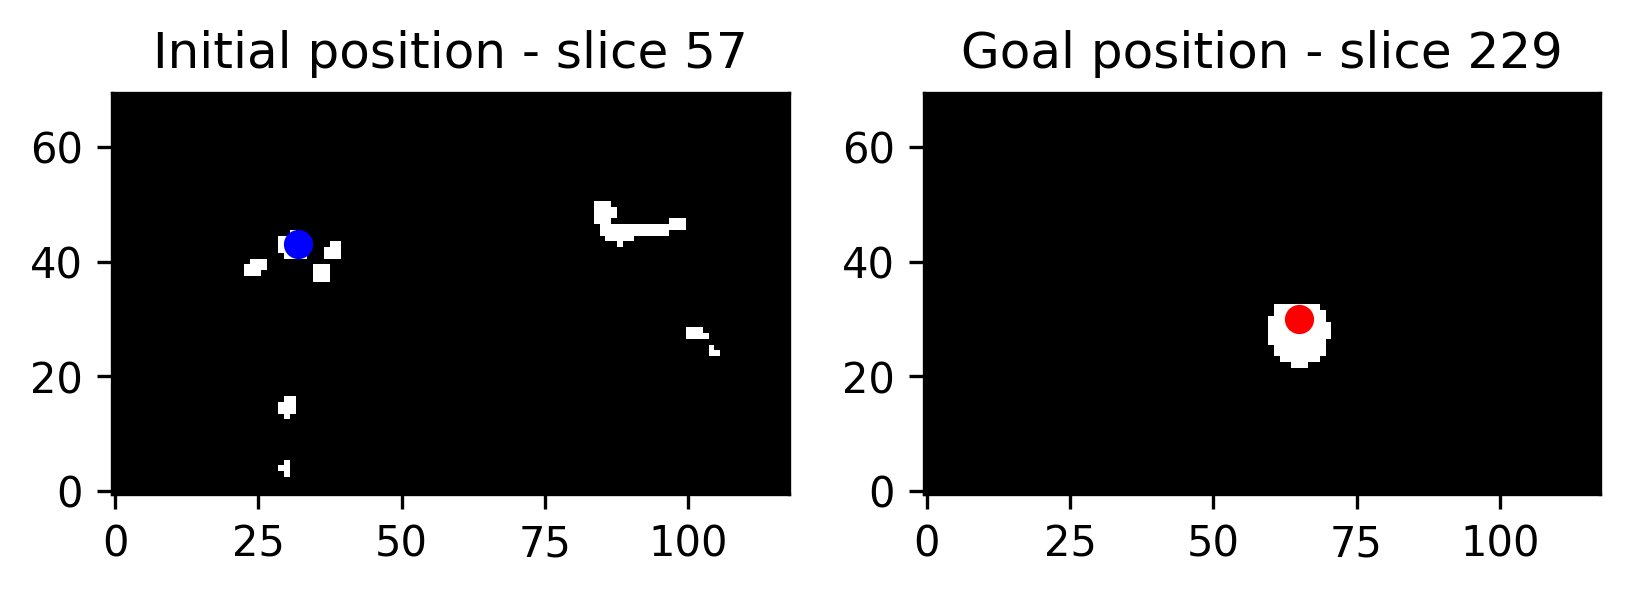

In [11]:
nb_slice = downscaled_labels.shape[0]
init_position = (nb_slice // 4, 43, 32)
goal_pos = (nb_slice - 2, 30, 65)

fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(downscaled_labels[init_position[0], :, :], cmap="grey", origin="lower")
ax[0].plot(init_position[2], init_position[1], "bo")
ax[0].set(title=f"Initial position - slice {init_position[0]}")
ax[1].imshow(downscaled_labels[goal_pos[0], :, :], cmap="gray", origin="lower")
ax[1].plot(goal_pos[2], goal_pos[1], "ro")
ax[1].set(title=f"Goal position - slice {goal_pos[0]}")
# Check if points are inside the label mask
print(f"Initial pos in binary map ? {downscaled_labels[init_position]}\nInitial pos in binary map ? {downscaled_labels[goal_pos]}")
#np.nonzero(downscaled_labels[init_pos[0]])

In [12]:
path = astar(~downscaled_labels, init_position, goal_pos)
if path:
    path.append(init_position)
print(path)

[(229, 30, 65), (228, 30, 65), (227, 30, 65), (226, 30, 65), (225, 30, 65), (224, 30, 65), (223, 30, 65), (222, 30, 65), (221, 30, 65), (220, 30, 65), (219, 30, 65), (218, 30, 65), (217, 30, 65), (216, 30, 65), (215, 30, 65), (214, 30, 65), (213, 30, 65), (212, 30, 65), (211, 30, 65), (210, 30, 65), (209, 30, 65), (208, 30, 65), (207, 30, 65), (206, 30, 65), (205, 30, 65), (204, 30, 65), (203, 30, 65), (202, 30, 65), (201, 30, 65), (200, 30, 65), (199, 30, 65), (198, 30, 65), (197, 30, 65), (196, 30, 65), (195, 30, 65), (194, 30, 65), (193, 30, 65), (192, 30, 65), (191, 30, 65), (190, 30, 65), (189, 30, 65), (188, 30, 65), (188, 30, 64), (187, 30, 64), (186, 30, 64), (186, 30, 63), (185, 30, 63), (184, 30, 63), (183, 30, 63), (182, 30, 63), (182, 30, 62), (182, 31, 62), (181, 31, 62), (180, 31, 62), (179, 31, 62), (179, 32, 62), (178, 32, 62), (177, 32, 62), (176, 32, 62), (176, 33, 62), (175, 33, 62), (174, 33, 62), (173, 33, 62), (172, 33, 62), (171, 33, 62), (171, 33, 61), (171, 34,

We can easily visualize the trajectory returned by A*

In [13]:
viewer = napari.view_image(downscaled_labels, name="label")
track = np.zeros((len(path), 5), dtype=np.float32)
track[:, 2:] = np.array(path)
track[:,2] = track[:,2]
track[:,1] = np.arange(len(path))
viewer.add_points([init_position, goal_pos], size=5, face_color='red')
# viewer.add_tracks(track, name="Path")
viewer.add_points(path, size=1, face_color='green')


<Points layer 'Points [1]' at 0x1aa0dd61a80>

We can now solve the laplace equation with Drichlet boundary conditions in 1D and then extend it to 3D

In [ ]:
nx = len(path)
laplace_1D = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx), format="csr") 
laplace_1D[0, 0] = 1
laplace_1D[0, 1] = 0
laplace_1D[-1, -1] = 1
laplace_1D[-1, -2] = 0
rhs_1D = np.zeros(len(path))
rhs_1D[0] = 10
rhs_1D[-1] = 1
solution_1D = splinalg.spsolve(laplace_1D, rhs_1D)
plt.plot(solution_1D)

Test with emmiting boundary conditions

In [ ]:
# frontier: np.ndarray = ndi.binary_dilation(downscaled_labels, iterations=1) & ~downscaled_labels
# frontier_index = frontier.flat > 0

new_steps = 2 * steps 
tic = time.perf_counter()
laplace_mat = create_laplacian_matrix_3d(*downscaled_labels.shape, 1, 1, 1)
toc = time.perf_counter()
print(f"Laplacian matrix creation: {toc - tic:.2f} seconds")
# Now we can define the proper coefficients for the laplacian matrix
rhs = np.zeros(laplace_mat.shape[0], dtype=np.float64)
goal_mask = np.zeros_like(downscaled_labels, dtype=float)
# We just initialise the solution with the path
for i, pos in enumerate(path):
    goal_mask[pos] = solution_1D[i]
# binary_map = 10 * frontier + goal_mask

# We need to set the boundary condition for the goal
tic = time.perf_counter()
laplace_mat, rhs = apply_dirichlet(laplace_mat, goal_mask)
toc = time.perf_counter()
print(f"Application of dirichlet BC : {toc - tic:.2f} seconds")

As before, we can have a look at what the rhs looks like

In [ ]:
plt.imshow(rhs.reshape(downscaled_labels.shape)[nb_slice // 2, :, :], cmap='inferno')

We can now solve the linear system to see if we get a correct landscape

In [ ]:
# valid_idx = (downscaled_labels.flat > 0) | (frontier.flat > 0)
valid_map = (downscaled_labels.flat > 0)

A = laplace_mat[valid_map, :][:, valid_map]
b = rhs[valid_map]
# b = binary_map.flat[valid_idx]
tic = time.perf_counter()
sol = splinalg.spsolve(A, b)
tac = time.perf_counter()
print(f"Linear system solved in: {tac - tic:.2f} seconds")
solution = np.zeros_like(downscaled_labels, dtype=np.float64)
solution.flat[valid_map] = sol

In [ ]:
viewer = napari.view_image(
    downscaled_labels, name="label", colormap="red",  scale=steps,
)
# viewer.add_image(valid_idx.reshape(label.shape), name="valid_idx", scale=steps, colormap="gray")
viewer.add_points(path, size=1, face_color='green', scale=steps)
# viewer.add_image(rhs.reshape(downscaled_labels.shape), name="rhs", scale=steps, colormap="gray")
viewer.add_image(
    solution, name="1D + 3D solve of the diffusion", colormap="inferno", blending="additive", scale=steps
)
napari.run()

# Definition of the simumlation !
We can now plug the result into our simulation pipeline to see how we can increase the distance to the border.

In [ ]:
from napari_potential_field_navigation.simulations import FreeNavigationSimulation
from napari_potential_field_navigation.fields import ScalarField3D, VectorField3D, Box3D, map_value_to_idx
import phi.flow as pf

import taichi as ti
import taichi.math as tm

ti.init(arch=ti.gpu)

class PointVectorField(VectorField3D):
    @ti.func
    def at(self, pos):
        idx = tm.ivec3([0, 0, 0])
        for i in ti.static(range(3)):
            temp_idx = map_value_to_idx(
                pos[i],
                self._bounds.min[i],
                self._bounds.max[i],
                self.step_sizes[i],
            )
            # Handle extrapolation
            if temp_idx == -1:
                idx[i] = 0
            elif temp_idx == -2:
                idx[i] = self._values.shape[i] - 2
            else:
                idx[i] = temp_idx
        return self._values[idx]

bounds = Box3D(min=tm.vec3(0.,0.,0.), max=tm.vec3(x_max, y_max, z_max))
values : np.ndarray = force_field.values.numpy('x,y,z,vector')
vector_field = VectorField3D(values, bounds)
vector_field.normalize()

Let first write a function to visualize the vector field in 3D.

In [ ]:
def visualize_vector_field(vector_field: VectorField3D, path: list = None, viewer = None, steps = None):
    values = vector_field.values
    
    norm = np.linalg.norm(values, axis=-1)
    if path is None:
        valid_idx = norm > 1e-3
        X, Y, Z = vector_field.meshgrid 

        data = np.zeros((valid_idx.sum(), 2, 3))
        data[:, 0, 0] = X[valid_idx]
        data[:, 0, 1] = Y[valid_idx]
        data[:, 0, 2] = Z[valid_idx]
        data[:, 1, :] = values[valid_idx]
    else:
        data = np.zeros((len(path), 2, 3))
        for i, pos in enumerate(path):
            data[i, 0, :] = pos
            data[i, 1, :] = values[pos]
    if viewer is None:
        viewer = napari.Viewer()
    viewer.add_vectors(
        data, 
        ndim=3, 
        name="Vector field",
        scale=steps,
    )
    return viewer

In [ ]:
# Let's redefine the 
init_pos_ar = np.array([init_position])
goal_pos_ar = np.array(goal_pos)

tmax = 100
dt = 1
D=0

simulation = FreeNavigationSimulation(init_pos_ar, goal_pos_ar, vector_field, t_max=tmax, dt=dt, diffusivity=D)
simulation.reset()
simulation.run()

In [ ]:

def view_the_all_thing(label, solution, vector_field, init_pos, goal_pos, simulation, steps, path = None):
    viewer = napari.view_image(
        label, name="label", colormap="gray", scale=steps,
    )
    viewer.add_points([init_pos, goal_pos], size=5, face_color='red', scale=steps)
    viewer.add_image(
        solution, name="1D + 3D solve of the diffusion", colormap="inferno", blending="additive", scale=steps
    )
    visualize_vector_field(vector_field, viewer=viewer, path = path, steps=steps)
    viewer.add_tracks(simulation.trajectories, scale=steps, name="Trajectories")
    if path is not None:        
        viewer.add_points(path, size=1, face_color='green', scale=steps, name="Initial path")
    return viewer

In [ ]:
v = view_the_all_thing(downscaled_labels, solution, vector_field, init_position, goal_pos, path, simulation, steps)
napari.run()

# Let's do a more stupid thing : use a wavefront map !
Basicaly we will first create a map indicating the distance to the source and use this information to go to the target location

In [6]:
from napari_potential_field_navigation._a_star import  wavefront_generation
nb_slices = label.shape[0]
goal_position = (nb_slices-2, 53, 128)

cost_map = wavefront_generation(~ndi.binary_dilation(label), goal_position)

[Taichi] version 1.7.0, llvm 15.0.1, commit 2fd24490, win, python 3.10.13


In [ ]:
np.savez_compressed("coast_map.npz", cost_map=cost_map, goal=np.array(goal_position), label=ndi.binary_dilation(label))

In [7]:
def visualize_field(field: np.ndarray, label : np.ndarray, downscale: int = 1, viewer = None):
    assert field.ndim == 3, "The field must be 3D"
    assert label.shape == field.shape, "The label and field dimensions must match"
    x_max, y_max, z_max = field.shape
    dx, dy, dz = np.gradient(field, edge_order=2)
    dx.fill_value = dy.fill_value = dz.fill_value = 0.0
    X, Y, Z = np.meshgrid(np.arange(x_max), np.arange(y_max), np.arange(z_max), indexing='ij')
    # Vector field representation
    valid_map = ~(dx.mask | dy.mask | dz.mask)
    if downscale > 1:
        downscale_map = np.zeros_like(field, dtype=bool)
        downscale_map[::downscale, ::downscale, ::downscale] = True
        valid_map = valid_map & downscale_map
        
    data = np.zeros((valid_map.sum(), 2, 3))
    data[:, 0, 0] = X[valid_map]
    data[:, 0, 1] = Y[valid_map]
    data[:, 0, 2] = Z[valid_map]
    data[:, 1, 0] = -dx[valid_map] 
    data[:, 1, 1] = -dy[valid_map]
    data[:, 1, 2] = -dz[valid_map]
    
    if viewer is None:
        viewer = napari.view_image(
        np.where(field.mask, 0, field.data), name="Field", colormap="inferno",
    )
    else:
        viewer.add_image(
            np.where(field.mask, 0, field.data), name="Field", colormap="inferno",
        )
    viewer.add_labels(label, name="Label")
    viewer.add_vectors(
        data, 
        ndim=3, 
        name="Vector field",
    )
    

    return viewer

In [9]:
viewer = visualize_field(cost_map, label, downscale=1)

In [16]:
# It's time to see if it works !
from napari_potential_field_navigation.simulations import FreeNavigationSimulation
from napari_potential_field_navigation.fields import ScalarField3D, VectorField3D, Box3D

import taichi as ti
import taichi.math as tm

ti.init(arch=ti.gpu)

init_position = np.array([(nb_slices // 2, 80, 100)], dtype=np.float32)
tmax = 100
dt = 1
D = 0

bounds = Box3D(min=tm.vec3(0.,0.,0.), max=tm.vec3(cost_map.shape))
dx, dy, dz = np.gradient(cost_map, edge_order=2)
dx[dx.mask] = 0
dy[dy.mask] = 0
dz[dz.mask] = 0
values = np.stack([-dx, -dy, -dz], axis=-1)
vector_field = VectorField3D(values, bounds)
assert np.array_equal(vector_field.values, values)

simulation = FreeNavigationSimulation(init_position, np.array(goal_position), vector_field, t_max=tmax, dt=dt, diffusivity=D)
simulation.reset()
simulation.run()

[Taichi] Starting on arch=cuda


In [17]:
def visualize_trajectories(cost_map, label_map, simulation, init_pos, goal_pos, path = None):
    viewer = visualize_field(cost_map, label_map)
    viewer.add_points([init_pos, goal_pos], size=3, face_color=['blue','green'])
    
    viewer.add_tracks(simulation.trajectories, scale=steps, name="Trajectories")
    if path is not None:        
        viewer.add_points(path, size=1, face_color='green', scale=steps, name="Initial path")
    return viewer

In [18]:
visualize_trajectories(cost_map, label, simulation, init_position[0], goal_position)

Viewer(camera=Camera(center=(0.0, 69.0, 117.0), zoom=2.874255319148936, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(0.0, 115.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=4, ndisplay=2, last_used=0, range=((0.0, 100.0, 1.0), (0.0, 462.0, 0.5), (-0.25, 138.75, 0.8203125), (-0.08984375, 234.91015625, 0.8203125)), current_step=(0, 230, 69, 117), order=(0, 1, 2, 3), axis_labels=('0', '1', '2', '3')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Field' at 0x1aa108f8c70>, <Labels layer 'Label' at 0x1aa172b30a0>, <Vectors layer 'Vector field' at 0x1aa1f50ffa0>, <Points layer 'Points' at 0x1aa1f5549a0>, <Tracks layer 'Trajectories' at 0x1aa17318250>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

In [19]:
with np.load('coast_map.npz') as data:
    cost_map = data['cost_map']
    goal_pos = data['goal']
    label = data['label']
print(cost_map.shape, goal_pos, label.shape)

(462, 139, 235) [460  53 128] (462, 139, 235)
